___

<div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 24px; font-weight: bold;">
Dataset Exploration
  </span>
</div>

___

<p><p>
<div class="alert alert-block alert-info" style="color: #0277BD; background-color: #E1F5FE;">
    

<p>In this notebook, we will explore four datasets stored in DuckDB using PySpark. The datasets include the Criminal Dataset, Airbnb Listings, TripAdvisor Attractions, and Restaurants. The exploration will involve:</p>
<ul>
<li>Identification of Data Quality rules on the datasets</li>
<li>Assessment of the Quality of the Data</li>
<li>Application of Data Cleaning processes (individually per dataset)</li>
<li>Expression of Data quality rules as Denial Constraints</li>
<li>Storage of the improved quality tables in the Trusted Zone, mirroring the tables in the Formatted Zone</li>
</ul>
</div>



In [1]:
#!pip install duckdb
#!pip3 install pyspark
#!pip install folium geopy
#!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
#!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS pyspark_postgres;'
#!sudo -u postgres psql -U postgres -c 'CREATE DATABASE pyspark_postgres;'
#!wget -O "postgresql.jar" "https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar"
#!wget -O "duckdb.jar" "https://repo1.maven.org/maven2/org/duckdb/duckdb_jdbc/0.10.1/duckdb_jdbc-0.10.1.jar"

In [2]:
## Imports
import duckdb
import pyspark
from pyspark.sql import SparkSession
from pprint import pprint
from pyspark.sql.functions import isnan, concat_ws, expr, split, when, count, collect_list, col,rand, regexp_replace, trim, lit, size, rand
import pandas as pd # -> Visualization
import warnings
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
import pickle
import time
import folium
import random
warnings.filterwarnings("ignore")

## Connection to formatted database
jdbc_url = 'jdbc:duckdb:./../data/formatted_zone/barcelona.db'
driver = "org.duckdb.DuckDBDriver"


# SparkSession inicialitzation
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .appName("DataExploration") \
    .getOrCreate()


24/04/25 18:04:23 WARN Utils: Your hostname, Julias-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.134 instead (on interface en0)
24/04/25 18:04:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/04/25 18:04:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/25 18:04:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/25 18:04:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold;">
     Criminal Dataset
  </span>
</div>

In [3]:
df = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_criminal_dataset") \
  .load()

df.limit(2).toPandas() 

,any,n_m_mes,nom_mes,regi_policial_rp,rea_b_sica_policial_abp,prov_ncia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,t_tol_del_fet_codi_penal,tipus_de_fet_codi_penal_o,mbit_fet,nombre_fets_o_infraccions,nombre_v_ctimes
0,2021,12,Desembre,RP Metropolitana Nord,ABP Badalona,Barcelona,Barcelonès,Badalona,Via pública urbana,Presencial,Delictes,De les lesions,Lesions,Sexisme,1,1.0
1,2021,6,Juny,RP Central,ABP Anoia,Barcelona,Anoia,Resta municipis ABP Anoia,Habitatge - Escala/portal finca/replà,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Sexisme,1,1.0


### Column names

<div class="alert alert-block alert-info" style="color: #0277BD; background-color: #E1F5FE;">

 - Correct the column names:
      - `n_m_mes` -> `num_mes`
      - `regi_policial_rp` -> `regio_policial`
      - `rea_b_sica_policial_abp` -> `area_basica_policial`
      - `t_tol_del_fet_codi_penal` -> `titol_del_fet_codi_penal`
      - `tipus_de_fet_codi_penal_o` -> `tipus_de_fet_codi_penal`
      - `mbit_fet` -> `ambit_fet`
      - `prov_ncia` -> `provincia`
</div>

In [4]:
# Correct the column names
df = df.withColumnRenamed("n_m_mes", "num_mes") \
       .withColumnRenamed("regi_policial_rp", "regio_policial") \
       .withColumnRenamed("rea_b_sica_policial_abp", "area_basica_policial") \
       .withColumnRenamed("t_tol_del_fet_codi_penal", "titol_del_fet_codi_penal") \
       .withColumnRenamed("tipus_de_fet_codi_penal_o", "tipus_de_fet_codi_penal") \
       .withColumnRenamed("mbit_fet", "ambit_fet") \
       .withColumnRenamed("prov_ncia", "provincia") \
       .withColumnRenamed("nombre_v_ctimes", "nombre_victimes")

### Schema

In [5]:
df.printSchema()

root
 |-- any: decimal(20,0) (nullable = true)
 |-- num_mes: decimal(20,0) (nullable = true)
 |-- nom_mes: string (nullable = true)
 |-- regio_policial: string (nullable = true)
 |-- area_basica_policial: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- comarca: string (nullable = true)
 |-- municipi: string (nullable = true)
 |-- tipus_de_lloc_dels_fets: string (nullable = true)
 |-- canal_dels_fets: string (nullable = true)
 |-- tipus_de_fet: string (nullable = true)
 |-- titol_del_fet_codi_penal: string (nullable = true)
 |-- tipus_de_fet_codi_penal: string (nullable = true)
 |-- ambit_fet: string (nullable = true)
 |-- nombre_fets_o_infraccions: decimal(20,0) (nullable = true)
 |-- nombre_victimes: double (nullable = true)



<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
#### DataFrame Schema
- The DataFrame contains various columns representing different aspects of criminal incidents.
- The columns include information such as the year (`any`), month number (`num_mes`), month name (`nom_mes`), police region (`regio_policial`), basic police area (`area_basica_policial`), province (`provincia`), county (`comarca`), municipality (`municipi`), type of location of the events (`tipus_de_lloc_dels_fets`), channel of the events (`canal_dels_fets`), type of crime (`tipus_de_fet`), title of the crime penal code (`titol_del_fet_codi_penal`), crime penal code type (`tipus_de_fet_codi_penal`), crime scope (`ambit_fet`), number of events or infractions (`nombre_fets_o_infraccions`), and number of victims (`nombre_victimes`).
- The data types of the columns include decimal, string, and double, with some columns with null values.

</div>


### Describe

In [6]:
df.describe().toPandas() 

24/04/25 18:04:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,count,2289,2289,2289,2289,2289,2289,2289,2289,2288,2289,2289,2289,2289,2289,2289,863
1,mean,2021.7741,6.7051,None,None,None,None,None,None,None,None,None,None,None,None,1.0000,1.2966396292004636
2,stddev,1.0871606296548673,3.2524835989513767,None,None,None,None,None,None,None,None,None,None,None,None,0.0,0.7321425942635059
3,min,2020,1,Abril,RP Metropolitana Nord,ABP Alt Camp - C. de Barberà,Barcelona,ABP Tarragonès,ABP el Prat de Llobregat,AERO - Altres comerços T1-Arribades,Int. i/o Xarxes,ALTRES,01.-DE L'HOMICIDI I LES SEVES FORMES,Abusos sexuals,Antigitanisme,1,0.0
4,max,2023,12,setembre,RP Terres de l'Ebre,Unitat d'informació RPMB,Tarragona,Vic,Àger,Zona/Eix comercial,Presencial,Infracció administrativa,NORMATIVA ESPORT: DLEG 1/00 I LLEIS 10/90 I 19/07,Violència física o psíquica habitual en l'àmbi...,Ètnic/origen nacional/origen racial,1,7.0


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Summary Observations:
- **Count**: 2289 records for all columns except for "tipus_de_lloc_dels_fets" which has 2288 records.

- The "num_mes" column has a mean value of approximately 6.71, indicating that the data spans multiple months.
- There are 863 records with values in the "nombre_victimes" column, suggesting incidents involving victims.

</div>

### Null Values

In [7]:
# Counting the NaN values
nan_counts = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
nan_counts.toPandas()

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

##### NULL VALUES == 0

+ No need to apply changes
</div>


### Filter by region in Barcelona

`[ABP Eixample, ABP Sants-Montjuïc, ABP Les Corts, ABP Horta-Guinardó, ABP Sant Martí, ABP Sarrià-Sant Gervasi, ABP Gràcia, ABP Sant Andreu, ABP Ciutat Vella]`



In [8]:
df.select("area_basica_policial").distinct().show()

+--------------------+
|area_basica_policial|
+--------------------+
|CD Caldes de Montbui|
|ABP Hospitalet de...|
|  ABP Horta-Guinardó|
|        ABP Berguedà|
|       ABP Barcelona|
|       ABP Les Corts|
|   ABP Premià de Mar|
|       ABP Tarragona|
|ABP Sant Feliu de...|
|          ABP Girona|
|   ABP Selva Litoral|
|        ABP Terrassa|
|        ABP Solsonès|
|ABP Sant Boi de L...|
|ABP Sant Vicenç d...|
|         ABP Tortosa|
|Unitat d'informac...|
|           ABP Osona|
|   ABP Pineda de Mar|
|        ABP Vendrell|
+--------------------+
only showing top 20 rows



In [9]:
# Filter by region in Barcelona: [ABP Eixample, ABP Sants-Montjuïc, ABP Les Corts, ABP Barcelona]
df_filtered = df.filter(df["area_basica_policial"].isin("ABP Eixample", "ABP Sants-Montjuïc", "ABP Les Corts", "ABP Horta-Guinardó", 
                                                        "ABP Sant Martí", "ABP Nou Barris", "ABP Sarrià-Sant Gervasi","ABP Gràcia", "ABP Sant Andreu", "ABP CIUTAT VELLA", "ABP Ciutat Vella"))

df_filtered = df_filtered.withColumn("area_basica_policial", regexp_replace("area_basica_policial", "^ABP ", ""))
df_filtered.limit(4).toPandas()

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,RP Metropolitana Barcelona,Nou Barris,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,RP Metropolitana Barcelona,Eixample,Barcelona,Barcelonès,Barcelona,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0
2,2020,1,Gener,RP Metropolitana Barcelona,Sant Andreu,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la Constitució,Contra exercici drets fonamentals i llibertats...,"Ètnic, origen nacional i/o racial",1,2.0
3,2020,1,Gener,RP Metropolitana Barcelona,Sants-Montjuïc,Barcelona,Barcelonès,Barcelona,Transport públic - Renfe - Adif - Estació,Presencial,Delictes,De les lesions,Lesions,"Ètnic, origen nacional i/o racial",1,1.0



### Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

<p>In this step, we remove the redundant columns from the DataFrame that are not of interest for our analysis. These columns include "provincia", "comarca", "municipio", and "regio_policial".  All the regions, provinces, and comarcas are located within Barcelona.</p>
</div>



In [10]:
columns_to_drop = ["provincia", "comarca", "municipi", "regio_policial"]
df_filtered = df_filtered.drop(*columns_to_drop)

In [11]:
df_filtered.limit(2).toPandas()

,any,num_mes,nom_mes,area_basica_policial,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,Nou Barris,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,Eixample,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Numeric Features Distributions Insights:
- Feature `nombre_fets_o_infraccions` -> All the values concentrated in 1 --> Redudant Col --> Drop
- None values in feature `nombre_victimes` -> Replace each None value with 0
- More criminality acts in 2023
- In summer and Spring (May and July) is the month with more criminal acts
  in Barcelona and December the least.
  - We'll keep both the `num_mes` and `nom_mes` variables for visualization purposes.
- Most criminal cases have  1 victim and a maximum of 7 victims with a low concentration.

</div>

In [12]:
# Replace each None -> 1 victims (minimum per dencuncia)
df_filtered = df_filtered.withColumn('nombre_victimes', when(col('nombre_victimes').isNull(), 1).otherwise(col('nombre_victimes')))

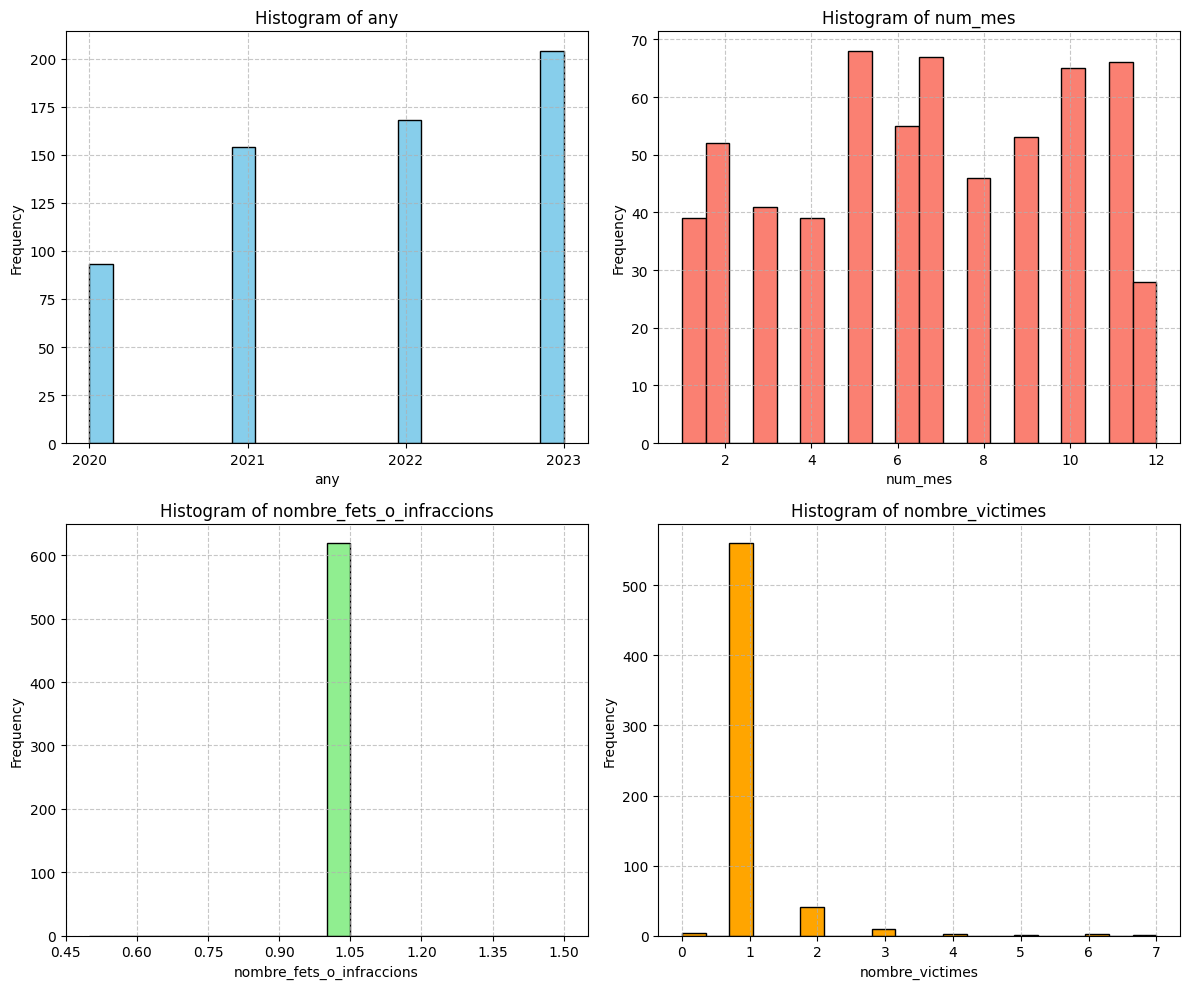

In [13]:
def plot_numeric_histograms(df):
    numeric_columns = ['any', 'num_mes', 'nombre_fets_o_infraccions', 'nombre_victimes']
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  
    axs = axs.flatten()  
    
    for i, column in enumerate(numeric_columns):
        column_data = df.select(column).rdd.flatMap(lambda x: x).collect()
        '''
        # nombre_victimes --> None values
        for x in column_data:
            if x == None:
                print(column)
                print(x)
        '''
        #column_data = [int(x) for x in column_data if x is not None]

        if column_data:
            ax = axs[i] 
            frequencies, bins, _ = ax.hist(column_data, bins=20, color=colors[i], edgecolor='black')
            ax.set_title(f'Histogram of {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
    
    plt.tight_layout()
    plt.show()


plot_numeric_histograms(df_filtered)

In [14]:
# Remove redundant col --> nombre_fets_o_infraccions
df_filtered = df_filtered.drop('nombre_fets_o_infraccions')

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Categorical Features Distributions Insights:
+ Examining the `"area_basica_policial"` variable reveals technical data cleaning improvements where the `"Ciutat Vella"` basic police area is inconsistently spelled in uppercase and lowercase → unify.
- Interestingly, `"Eixample"` and `"Ciutat Vella"` are the regions where hate crimes occur most frequently.
- The `"tipus_de_fet"` variable indicates that the majority of incidents are crimes, but the variable itself is redundant for our study → drop.
- The `"ambit_fet"` feature indicates the type of crime, with hate crimes based on LGTBI-fobia standing out significantly with a much higher ratio than others.
- The `"canal_dels_fets"` variable indicates whether incidents were reported through social channels or in person. Since our study focuses on street incidents in Barcelona, non-face-to-face criminal acts will not be considered.

</div>

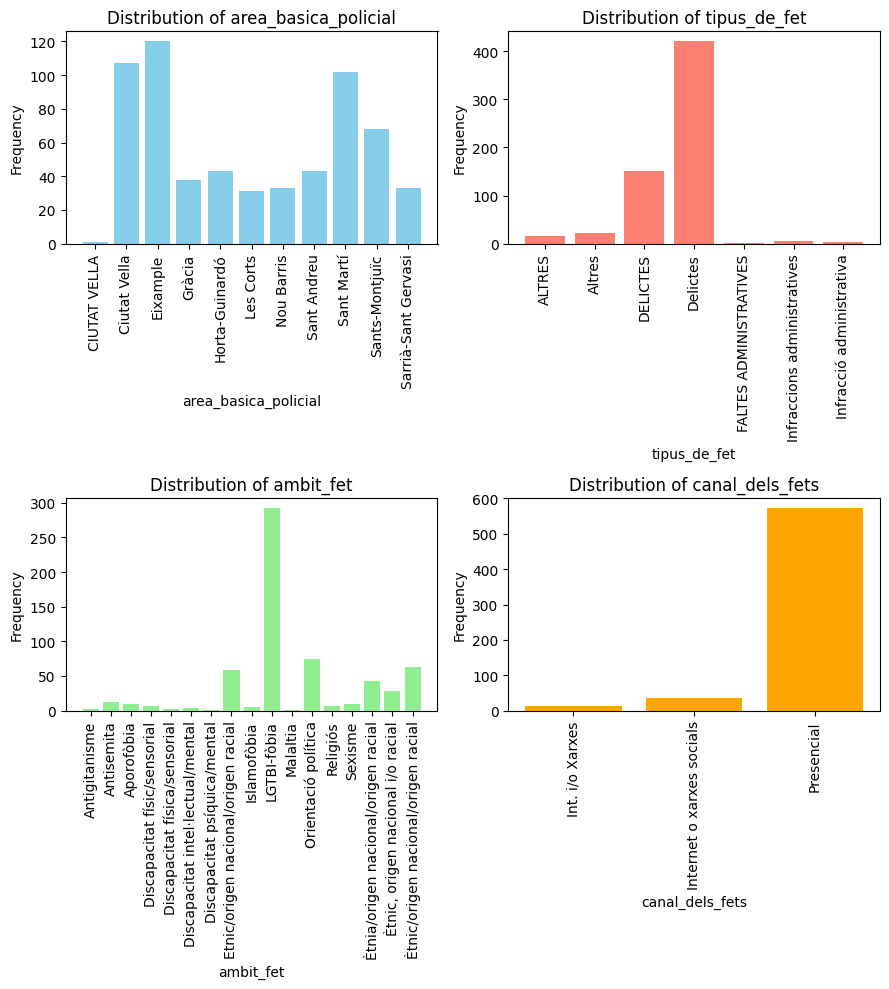

In [15]:
def plot_categorical_distribution(df, column, ax, color):
    counts = df.groupBy(column).count().orderBy(column).collect()
    labels = [row[column] for row in counts]
    frequencies = [row['count'] for row in counts]
    ax.bar(labels, frequencies, color=color)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {column}')
    ax.tick_params(axis='x', rotation=90)

# Categorical features 
categorical_columns = ['area_basica_policial', 'tipus_de_fet', 'ambit_fet', 'canal_dels_fets']

fig, axs = plt.subplots(2, 2, figsize=(9, 10))  
axs = axs.flatten()  # Aplanar la matriz de subplots
color_palette = ['skyblue', 'salmon', 'lightgreen', 'orange'] # Paleta de colores

for i, column in enumerate(categorical_columns):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_filtered, column, ax, color)

plt.tight_layout()
plt.show()

In [16]:
df_filtered.select("ambit_fet").distinct().show()
## uniify the col values and in english for visualization
# Define value unification rules

value_translation = {
    "Discapacitat psíquica/mental": "Psychological disability",
    "Discapacitat intel·lectual/mental": "Intellectual disability",
    "Orientació política": "Political orientation",
    "Ètnic/origen nacional/origen racial": "Ethnic/national/racial origin",
    "Sexisme": "Sexism",
    "Discapacitat física/sensorial": "Physical/sensory disability",
    "Discapacitat físic/sensorial": "Physical/sensory disability",    
    "Aporofòbia": "Aporophobia",
    "Discapacitat física/sensorial": "Physical/sensory disability",
    "Islamofòbia": "Islamophobia",
    "Ètnia/origen nacional/origen racial": "Ethnic/national/racial origin",
    "Etnic/origen nacional/origen racial": "Ethnic/national/racial origin",
    "Antisemita": "Antisemitism",
    "LGTBI-fòbia": "LGBTI-phobia",
    "Antigitanisme": "Anti-gypsyism",
    "Ètnic, origen nacional i/o racial": "Ethnic/national/racial origin",
    "Malaltia": "Illness",
    "Religiós": "Religious"
}

for original, translated in value_translation.items():
    df_filtered = df_filtered.withColumn("ambit_fet", when(df_filtered["ambit_fet"] == original, translated).otherwise(df_filtered["ambit_fet"]))
df_filtered.select("ambit_fet").distinct().show()

+--------------------+
|           ambit_fet|
+--------------------+
|Discapacitat psíq...|
|Discapacitat inte...|
| Orientació política|
|Ètnic/origen naci...|
|             Sexisme|
|Discapacitat físi...|
|          Aporofòbia|
|Discapacitat físi...|
|         Islamofòbia|
|Ètnia/origen naci...|
|Etnic/origen naci...|
|          Antisemita|
|         LGTBI-fòbia|
|       Antigitanisme|
|Ètnic, origen nac...|
|            Malaltia|
|            Religiós|
+--------------------+

+--------------------+
|           ambit_fet|
+--------------------+
|Ethnic/national/r...|
|        Antisemitism|
|        Islamophobia|
|Intellectual disa...|
|Political orienta...|
|        LGBTI-phobia|
|       Anti-gypsyism|
|Psychological dis...|
|         Aporophobia|
|           Religious|
|Physical/sensory ...|
|             Illness|
|              Sexism|
+--------------------+



In [17]:
# CATEGORIC DATA CLEANING
# Replace Ciutat Vella uppercase
df_filtered = df_filtered.withColumn("area_basica_policial", 
                                     regexp_replace(df_filtered["area_basica_policial"], 
                                      "CIUTAT VELLA",   "Ciutat Vella"))

df_filtered = df_filtered.drop('tipus_de_fet')

# Filter the data to keep only the values where canals_dels_fets == "Presencial"
df_filtered = df_filtered.filter(df_filtered["canal_dels_fets"] == "Presencial")

# Drop canals_dels_fets --> Redundant
df_filtered = df_filtered.drop('canal_dels_fets')


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Textual Features  Insights -- Word Cloud

+ The variable `titol_de_fet_codi_penal` is not relevant for visualizing the results for our study -- Legislative
+ `Tipus de codi penal` requires preprocessing before the variable can be useful for the study
+ `Tipus de lloc dels fets`clearly highlights that the majority of crimes occur in public places, also inside residential premises (apartments, houses), as well as in building entrances or public transport.

</div>


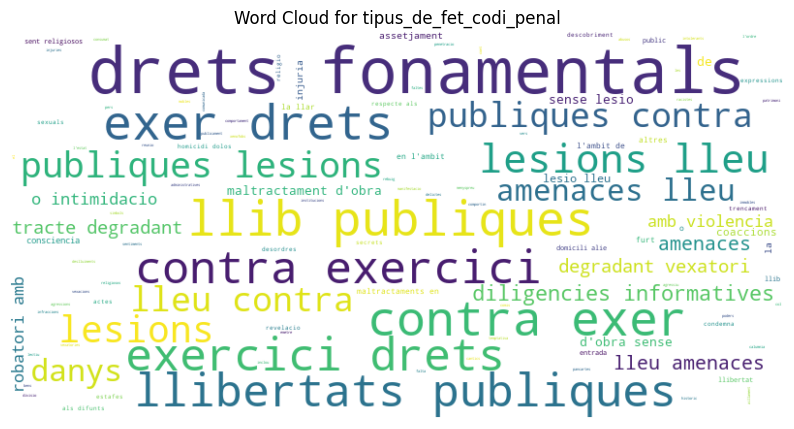

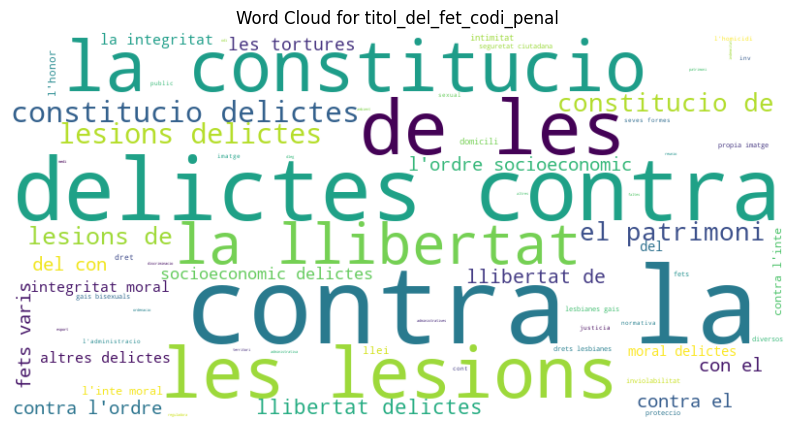

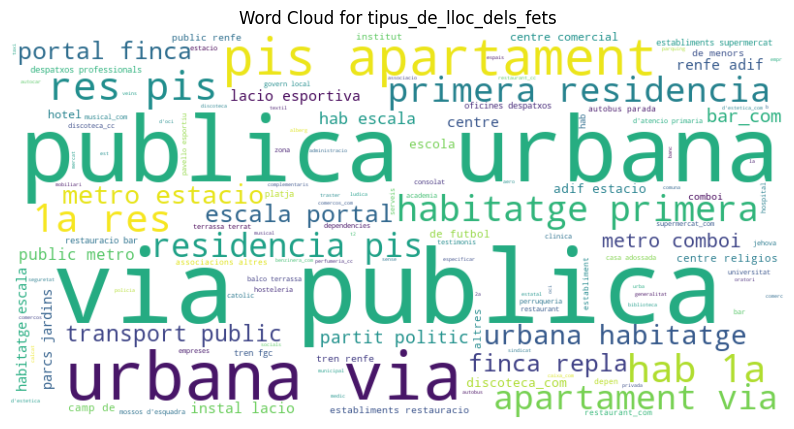

In [18]:
from wordcloud import WordCloud
from unidecode import unidecode

def generate_word_cloud(values, title):
    text = " ".join(unidecode(value).lower() for value in values) # Unifquem en minuscuels y sense accents x treure + insides
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Textual cols
columns_and_titles = {
    "tipus_de_fet_codi_penal": "Word Cloud for tipus_de_fet_codi_penal",
    "titol_del_fet_codi_penal": "Word Cloud for titol_del_fet_codi_penal",
    "tipus_de_lloc_dels_fets": "Word Cloud for tipus_de_lloc_dels_fets"
}

for column, title in columns_and_titles.items():
    values = df_filtered.select(column).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
    generate_word_cloud(values, title)


In [19]:
# Remove redundant col --> nombre_fets_o_infraccions
df_filtered = df_filtered.drop('titol_del_fet_codi_penal')

In [20]:
# Preprocessing --> tipus_de_lloc_dels_fets
tipus_de_lloc_dels_fets_values = df_filtered.select("tipus_de_lloc_dels_fets").rdd.flatMap(lambda x: x).filter(lambda x: x is  None).collect()
tipus_de_lloc_dels_fets_values # Nomes hi ha un none drop la mostra

[None]

In [21]:
df_filtered = df_filtered.filter(df_filtered.tipus_de_lloc_dels_fets.isNotNull())

In [22]:
df_criminal = df_filtered
df_criminal.limit(2).toPandas() 

,any,num_mes,nom_mes,area_basica_policial,tipus_de_lloc_dels_fets,tipus_de_fet_codi_penal,ambit_fet,nombre_victimes
0,2021,6,Juny,Nou Barris,Via pública urbana,Amenaces,Political orientation,1.0
1,2020,1,Gener,Eixample,Zona d'oci/lúdica,Robatori amb violència i/o intimidació,LGBTI-phobia,1.0


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold;">
     Airbnb Dataset
  </span>
</div>

In [23]:
df_airbnb = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_airbnb_listings") \
  .load()

df_airbnb.limit(4).toPandas()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,license,jurisdiction_names,cancellation_policy,calculated_host_listings_count,reviews_per_month,features,geolocation.lon,geolocation.lat,__index_level_0__
0,14618223,https://www.airbnb.com/rooms/14618223,20170407214050,2017-04-08,Piso cerca del Cam Nou,Acogedor y juvenil piso bien comunicado y en u...,Somos 2 chicos jóvenes y trabajadores que segu...,Acogedor y juvenil piso bien comunicado y en u...,none,None,...,10.0,None,NaN,moderate,1,0.13,"Host Has Profile Pic, Host Identity Verified, ...",2.122076,41.378150,0
1,476120,https://www.airbnb.com/rooms/476120,20170407214050,2017-04-08,Room @ Villa w/ beautiful garden.,Spacious room with much ligth and views with p...,Villa Maria was built for a famous Catalan ope...,Spacious room with much ligth and views with p...,none,Situated in a quiet neighborhood with all amen...,...,9.0,None,NaN,strict,1,0.66,"Host Has Profile Pic, Host Identity Verified, ...",2.104925,41.414866,1
2,5417379,https://www.airbnb.com/rooms/5417379,20170407214050,2017-04-08,Casa Tamarita near Parc Güell,Enjoy your stay in Barcelona in a cool and mod...,You will enjoy the comfy and efficient space o...,Enjoy your stay in Barcelona in a cool and mod...,none,Quiet neighborhood with nearby parks (includin...,...,9.0,HUTB-008587,NaN,strict,2,2.52,"Host Has Profile Pic, Host Identity Verified, ...",2.140766,41.410926,2
3,1703443,https://www.airbnb.com/rooms/1703443,20170407214050,2017-04-08,Clean & Cozy Room in Lovely Gracia,"Our apartment is small & basic, but has everyt...","THE APARTMENT This is a newly renovated, smoke...","Our apartment is small & basic, but has everyt...",none,None,...,10.0,None,NaN,strict,1,1.96,"Host Is Superhost, Host Has Profile Pic, Host ...",2.157887,41.400978,3



### Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ All records with broken links --> Drop
+ Perform extensive cleaning to remove redundant columns from the DataFrame that are not relevant for our analysis.
+ Summary == Description (same feature)


</div>



In [24]:
pd.set_option('display.max_columns', None)

columns_to_drop = ["id","listing_url", "Description", "experiences_offered", "scrape_id", "last_scraped", "jurisdiction_names", "thumbnail_url", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", "xl_picture_url","picture_url", "host_thumbnail_url", "host_neighbourhood", "host_url", "medium_url", "host_listings_count", "host_total_listings_count",  "__index_level_0__", "state", "license", "calendar_last_scraped", "calculated_host_listings_count", "first_review", "last_review", "has_availability", "calendar_updated"]
df_airbnb = df_airbnb.drop(*columns_to_drop)

#df_airbnb.limit(4).toPandas()


    
#### Location Features Unification


<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">
- All the apartments are located in Barcelona -> Remove the redundant cols in location stage that are the same
    - `['market', "city", "smart_location", "country", "country_code", "zipcode", ]
- `Market` feature -> Outliers that are not in barcelona --> Drop
- `Latitud`, `Longitud`, `geolocation.lon`, `geolocation.lat`
    - Are the same values?
- Relation data `neighbourhood` features & `criminal_dataset`
</div>

In [25]:
# Data Cleaning - Remove all the instance that the market is not Barcelona
df_airbnb.select("market").distinct().show()
df_airbnb = df_airbnb.filter(df_airbnb['market'] == 'Barcelona')

+----------------+
|          market|
+----------------+
|       Barcelona|
|    Buenos Aires|
|Costa Brava Nord|
|        Valencia|
|            NULL|
+----------------+



In [26]:
# Contry and city feature == same Barcelona and Spain -- Redudant 
# Zip code -- We have te gelocation data -- Redundant
df_airbnb.select("city").distinct().show()
df_airbnb.select("smart_location").distinct().show()
#df_airbnb.select("zipcode").distinct().show()
df_airbnb.select("country").distinct().show()
df_airbnb.select("country_code").distinct().show()

columns_to_drop = ["city", "zipcode", "smart_location", "country", "country_code", "market" ]
df_airbnb = df_airbnb.drop(*columns_to_drop)


+---------+
|     city|
+---------+
|Barcelona|
|barcelona|
+---------+

+-----------------+
|   smart_location|
+-----------------+
|Barcelona , Spain|
| barcelona, Spain|
| Barcelona, Spain|
|barcelona , Spain|
+-----------------+

+-------+
|country|
+-------+
|  Spain|
+-------+

+------------+
|country_code|
+------------+
|          ES|
+------------+



In [27]:
# Location change name -- solving text issues
column_mapping = dict(zip(df_airbnb.columns[-2:], ["geolocation_lon", "geolocation_lat"]))

for old_name, new_name in column_mapping.items():
    df_airbnb = df_airbnb.withColumnRenamed(old_name, new_name)


location = df_airbnb.select("geolocation_lon", "geolocation_lat", "latitude", "longitude").limit(5)
location.show()

# Same values -- Drop geolocation_lon and geolocation_lon
columns_to_drop = ["geolocation_lon", "geolocation_lat"]
df_airbnb = df_airbnb.drop(*columns_to_drop)

+------------------+------------------+------------------+------------------+
|   geolocation_lon|   geolocation_lat|          latitude|         longitude|
+------------------+------------------+------------------+------------------+
| 2.122075545481956|41.378150177192396|41.378150177192396| 2.122075545481956|
|2.1049250609405097|  41.4148655885311|  41.4148655885311|2.1049250609405097|
|2.1407658129075626|41.410925919974986|41.410925919974986|2.1407658129075626|
|2.1578867703448044| 41.40097836628479| 41.40097836628479|2.1578867703448044|
| 2.208579360995987| 41.42119449770243| 41.42119449770243| 2.208579360995987|
+------------------+------------------+------------------+------------------+



In [28]:
# Same data information -- MOST RELEVANT neighbourhood_group_cleansed == area_basica_policial (criminal dataset) 
df_airbnb.select("neighbourhood_cleansed").distinct().show()
df_airbnb.select("neighbourhood_group_cleansed").distinct().show()
df_airbnb.select("neighbourhood").distinct().show()

# Same values -- Drop geolocation_lon and geolocation_lon
columns_to_drop = ["neighbourhood_cleansed", "neighbourhood"]
df_airbnb = df_airbnb.drop(*columns_to_drop)

CodeCache: size=131072Kb used=43815Kb max_used=43820Kb free=87256Kb
 bounds [0x000000010256c000, 0x000000010507c000, 0x000000010a56c000]
 total_blobs=14608 nmethods=13649 adapters=870
 compilation: disabled (not enough contiguous free space left)
+----------------------+
|neighbourhood_cleansed|
+----------------------+
|           el Poblenou|
|     la Vila de Gràcia|
|  el Besòs i el Mar...|
|          la Guineueta|
|          la Teixonera|
|  la Dreta de l'Eix...|
|           el Guinardó|
|        el Barri Gòtic|
|              Vallbona|
|             Canyelles|
|  Provençals del Po...|
|   la Verneda i la Pau|
|  Vilapicina i la T...|
|  l'Antiga Esquerra...|
|                 Navas|
|     la Marina de Port|
|                Sarrià|
|  la Marina del Pra...|
|            Torre Baró|
|      la Trinitat Nova|
+----------------------+
only showing top 20 rows



Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


+----------------------------+
|neighbourhood_group_cleansed|
+----------------------------+
|                      Gràcia|
|                  Sant Martí|
|              Horta-Guinardó|
|                   Les Corts|
|              Sants-Montjuïc|
|                  Nou Barris|
|         Sarrià-Sant Gervasi|
|                    Eixample|
|                 Sant Andreu|
|                Ciutat Vella|
+----------------------------+

+--------------------+
|       neighbourhood|
+--------------------+
|            El Raval|
|    La Vila Olímpica|
|El Camp de l'Arpa...|
|             El Clot|
|              Gràcia|
|Provençals del Po...|
|     Les Tres Torres|
|            Guinardó|
|La Maternitat i S...|
|          Sant Martí|
|Vilapicina i la T...|
|               Navas|
|Sant Pere, Sant C...|
|              Sarrià|
|          Torre Baró|
|             El Coll|
|   Glòries - El Parc|
|         Sant Antoni|
|Diagonal Mar - La...|
|    Les Corts (Nabe)|
+--------------------+
only showing 

In [29]:
# Same Name -- Relation -- Same col names 
df_airbnb = df_airbnb.withColumnRenamed("neighbourhood_group_cleansed", "neighbourhood")
df_filtered = df_filtered.withColumnRenamed("area_basica_policial", "neighbourhood")
df_airbnb.select("neighbourhood").distinct().show()
df_filtered.select("neighbourhood").distinct().show()

+-------------------+
|      neighbourhood|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+

+-------------------+
|      neighbourhood|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+



<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
#### DataFrame Schema selected for the project


The DataFrame comprises various groups of columns, each providing distinct details related to property listings:

- The DataFrame has **9999 rows** and **54 columns**.

**Property Information:**
- **name:** A string indicating the name of the property.
- **summary:** A string providing a brief overview of the property.
- **space:** A string describing the available space within the property.
- **neighborhood_overview:** A string offering insights into the neighborhood surrounding the property.
- **notes:** Additional notes or remarks about the property.

**Host Information:**
- **host_id:** An identifier for the host of the property.
- **host_name:** The name of the host.
- **host_since:** The date when the host joined the platform.
- **host_location:** The location of the host.
- **host_about:** Information or description about the host.

**Host Response Details:**
- **host_response_time:** The typical response time of the host.
- **host_response_rate:** The rate of responses from the host, represented as a double.
- **host_verifications:** Methods used to verify the host's identity.

**Location Details:**
- **street:** The street address of the property.
- **neighbourhood:** The name of the neighborhood where the property is located.
- **latitude:** The latitude coordinate of the property.
- **longitude:** The longitude coordinate of the property.

**Property Details:**
- **property_type:** The type or category of the property.
- **room_type:** The type of room available in the property (e.g., entire home, private room, shared room).
- **accommodates:** The maximum number of guests the property can accommodate, represented as a decimal.
- **bathrooms:** The number of bathrooms in the property, represented as a double.
- **bedrooms:** The number of bedrooms in the property, represented as a double.
- **beds:** The number of beds available in the property, represented as a double.
- **bed_type:** The type of bed(s) available in the property.
</div>

In [30]:
df_airbnb.printSchema()
print("The DataFrame has {} rows and {} columns.".format(df_airbnb.count(), len(df_airbnb.columns)))

root
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_verifications: string (nullable = true)
 |-- street: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: de

### NULL Values 

<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

- Majority of `square_feet` values are `NULL`, suggesting insignificance. The feature can be dropped.
- The column `Name` has only a single null value, which may require manual handling.
- For `Neighborhood overview`, we'll randomly select an overview from someone in the same neighborhood.
- If `security deposit` & `cleaning_fee` is `NULL`, it will be assumed to be 0.
- The most important feature for visualization is `Ratings` Therefore, apartments without review scores will be dropped.
- Apartments lacking certain variables such as `interaction`, `host_about`,`host_response_rate`, etc., will be labeled as `No information`  because of the visualizer.
</div>


In [31]:
nan_counts = df_airbnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airbnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features
0,1,0,2927,3921,5388,4033,4201,4606,3153,0,4,4,30,3505,1227,1227,0,0,0,0,0,0,0,0,16,11,21,0,0,9622,20,8593,8478,5128,3532,0,0,0,0,0,0,0,0,0,2067,2086,2082,2091,2086,2092,2095,0,1976,0


In [32]:
# Data Cleaning for NULL values
df_airbnb = df_airbnb.drop('square_feet')
df_airbnb = df_airbnb.filter(col("review_scores_value").isNotNull())
df_airbnb = df_airbnb.fillna({'security_deposit': 0})
df_airbnb = df_airbnb.fillna({'cleaning_fee': 0})
df_airbnb = df_airbnb.fillna({'host_response_rate': 0})

In [33]:
# List of columns to be labeled as "No information" if null
columns_to_fill = ['interaction', 'host_about', 'host_response_time', 'notes', 'host_location', 'house_rules', 'access', 'space', 'transit']
# Replace null values in the specified columns with "No information"
fill_values = {col: "No information" for col in columns_to_fill}
df_airbnb = df_airbnb.fillna(fill_values)

In [34]:
# Single Apartment with No Name
null_name_row = df_airbnb.filter(df_airbnb['Name'].isNull())
null_name_row.toPandas()

,name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features
0,None,Habitación amplia y luminosa en Les Corts. A 2...,No information,None,No information,No information,No information,No information,No information,14308783,Arnau,2014-04-15,"Barcelona, Catalonia, Spain",No information,a few days or more,0.0,"email, phone, linkedin, reviews, jumio, govern...","Barcelona, CT 08014, Spain",Les Corts,41.38352242639844,2.1359316561894386,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,"TV, Internet, Wireless Internet, Kitchen, Elev...",35.0,NaN,NaN,0.0,10.0,1,0,1,1125,29,59,89,364,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.1,"Host Has Profile Pic, Host Identity Verified, ..."


In [35]:
# New name for  None == name --> Manual fix
df_airbnb = df_airbnb.withColumn("Name", when(df_airbnb["name"].isNull(), 'Habitacion amplia en Les Corts').otherwise(df_airbnb["name"]))

### Handling Missing Values in "Neighborhood Overview"

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
We're addressing missing values in the "Neighborhood Overview" column by randomly selecting an overview from someone in the same neighborhood.

+ Group data by neighborhood.
+ Collect non-null neighborhood overviews into lists.
+ Calculate the length of overview lists.
+ Select random overviews from lists.
+ Join with original DataFrame.
+ Replace missing values with random overviews.

</div>



In [36]:
random_overviews = df_airbnb.groupBy('neighbourhood') \
    .agg(collect_list('neighborhood_overview').alias('overview_list')) \
    .withColumn('overview_count', size('overview_list')) \
    .withColumn('random_index', (rand() * col('overview_count')).cast('int')) \
    .select('neighbourhood', col('overview_list')[col('random_index')].alias('random_overview'))


df_airbnb = df_airbnb.join(random_overviews, 'neighbourhood', 'left_outer') \
    .withColumn('neighborhood_overview', when(col('neighborhood_overview').isNull(), col('random_overview')).otherwise(col('neighborhood_overview'))) \
    .drop('random_overview')


In [37]:
# Checking again the NULL values
nan_counts = df_airbnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airbnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,neighbourhood,Name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features
0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,15,9,16,0,0,7,6633,6482,0,0,0,0,0,0,0,0,0,0,0,1,3,5,2,2,1,0,0,0,0


<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

- **Majority of NULLs resolved** :)
- Only one null host requires manual handling: `host_name` & `host_since`
- Manual handling required for `host_response_rate` (15 samples), `bedrooms` (9 samples), and `beds` (16 samples)
- Price (7 null samples --> Inspect individually)
- NaN values in `weekly_price` and `monthly_price` to be calculated manually by multiplying `price` by 7 for weekly price and by 30 for monthly price.
- Droping the duplicates & Setting `apartment_id` for manual changes
- Replacing missing values in review score columns with `review_scores_value`

  
</div>

In [38]:
# Single Apartment with No Name
null_name_row = df_airbnb.filter(df_airbnb['host_name'].isNull())
null_name_row.toPandas()

,neighbourhood,Name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features
0,Eixample,Habitación doble.,Se trata de una habitación doble en un hermoso...,No information,Midtown Apartments es su privilegiada ubicació...,No information,No information,No information,No information,No information,28903973,None,None,No information,No information,No information,0.0,None,"Barcelona, Barcelona 08013, Spain",41.40605165227569,2.180347150933929,Bed & Breakfast,Private room,2,1.0,1.0,1.0,Real Bed,"Internet, Wireless Internet, Kitchen, Doorman,...",25.0,NaN,NaN,100.0,13.0,1,10,1,1125,0,0,0,0,8,87.0,9.0,8.0,10.0,10.0,9.0,9.0,moderate,0.35,Requires License


In [39]:
# New name for  host == Anonymous Host --> Manual fix
df_airbnb = df_airbnb.withColumn("host_name", when(df_airbnb["host_name"].isNull(), 'Anonymous Host').otherwise(df_airbnb["host_name"]))
df_airbnb = df_airbnb.withColumn("host_since", when(df_airbnb["host_since"].isNull(), '-').otherwise(df_airbnb["host_since"]))

In [40]:
# Droping the duplicates
df_sin_duplicados = df_airbnb.dropDuplicates(["host_id", "summary", "name"])

print('Nº of duplicates', df_airbnb.count() - df_sin_duplicados.count())

Nº of duplicates 665


In [41]:
df_airbnb = df_airbnb.dropDuplicates(["host_id", "summary", "name"])

In [42]:
# Replacing missing values in review score columns with review_scores_value
review_score_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                        'review_scores_checkin', 'review_scores_communication', 'review_scores_location']

for col_name in review_score_columns:
    df_airbnb = df_airbnb.withColumn(col_name, when(col(col_name).isNull(), col("review_scores_value")).otherwise(col(col_name)))

In [43]:
from pyspark.sql.functions import monotonically_increasing_id

df_airbnb = df_airbnb.withColumn("id", monotonically_increasing_id())

### Handling Missing Values of "Price"

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
+ Missing values for the `price` variable have been handled by calculating the daily price from the `weekly_price` for a specific row where `id` matches a certain value, and dropping rows where `price` is null because there is no available information.
+ NaN values in `weekly_price` and `monthly_price` to be calculated manually by multiplying `price` by 7 for weekly price and by 30 for monthly price.
</div>

In [44]:
null_prices = df_airbnb.filter(df_airbnb['price'].isNull())
null_prices.toPandas()

,neighbourhood,Name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features,id
0,Sants-Montjuïc,Apartment Plaza España 5pax 2rooms,This bright modern apartment for 5 people is l...,Our cool and modern apartment next to Plaza Es...,The Apartments are located in a privileged loc...,No information,Fira de Barcelona is located just 450 yards fr...,El moderno apartamento se encuentra al lado de...,No information,"Please, let me know your expected arrival time...",61081652,Ignacio,2016-03-01,"Barcelona, Catalonia, Spain","Hello! \r\nI'm from Barcelona, love traveling,...",within an hour,100.0,"email, phone, google, reviews, jumio, governme...","Sants-Montjuïc, Barcelona, Catalunya 08004, Spain",41.37211664937378,2.1493671314954734,Apartment,Entire home/apt,5,1.0,2.0,4.0,Real Bed,"TV, Wireless Internet, Air conditioning, Kitch...",NaN,NaN,NaN,0.0,0.0,1,0,2,8,16,46,66,334,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.91,"Host Has Profile Pic, Host Identity Verified, ...",8589935229
1,Sants-Montjuïc,Apartment Plaza España 5pax 3rooms,This bright modern apartment for 5 people is l...,Our cool and modern apartment next to Plaza Es...,The Apartments are located in a privileged loc...,No information,Fira de Barcelona is located just 450 yards fr...,No information,No information,"Please, let me know your expected arrival time...",61081652,Ignacio,2016-03-01,"Barcelona, Catalonia, Spain","Hello! \r\nI'm from Barcelona, love traveling,...",within an hour,100.0,"email, phone, google, reviews, jumio, governme...","Sants-Montjuïc, Barcelona, Catalunya 08004, Spain",41.372903929067,2.149750245544863,Apartment,Entire home/apt,5,1.0,3.0,5.0,Real Bed,"TV, Wireless Internet, Air conditioning, Kitch...",NaN,NaN,NaN,0.0,0.0,1,0,2,8,11,35,59,327,5,96.0,10.0,9.0,10.0,10.0,10.0,10.0,moderate,0.75,"Host Has Profile Pic, Host Identity Verified, ...",25769804467
2,Eixample,Modern style apartment España Sq!,Nro de inscripción (phone number hidden),"Hello Traveler! I share the same passion, trav...",Midtown Apartments es su privilegiada ubicació...,Tourist license available. Late checkin (after...,No information,No information,No information,- No smoking inside the house. - No visitors a...,2114929,Sergio,2012-04-11,"Barcelona, Cataluña, Spain",I am quite comprehensive host. I like to make ...,within an hour,100.0,"email, phone, facebook, reviews, jumio, work_e...","Sant Antoni, Barcelona, Catalonia 08015, Spain",41.37729175931742,2.15443665590417,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"Internet, Wireless Internet, Air conditioning,...",NaN,872.0,2725.0,200.0,300.0,2,35,100,1000,8,22,39,302,67,95.0,10.0,10.0,10.0,10.0,9.0,10.0,strict,1.54,"Host Has Profile Pic, Host Identity Verified, ...",34359738634
3,Ciutat Vella,Recently renovated apartment by beach.,"Beautiful spacious apartment, right next to th...",No information,PALAU DE LA MÚSICA VIA LAIETANA RAMBLAS ARCO D...,No information,No information,No information,No information,No information,48183618,Carlos,2015-11-04,ES,No information,within a few hours,100.0,"phone, reviews","La Barceloneta, Barcelona, Catalunya 08003, Spain",41.381467314044556,2.1889497629307773,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"TV, Wireless Internet, Air conditioning, Kitch...",NaN,NaN,NaN,0.0,40.0,2,5,30,1125,5,35,65,284,6,97.0,10.0,9.0,10.0,10.0,10.0,9.0,flexible,

In [45]:
# We found an apartmanet that have the weekly_price --> one day price calculation
df_airbnb = df_airbnb.withColumn("price", when(df_airbnb["id"] == 34359738634, df_airbnb["weekly_price"] / 7).otherwise(df_airbnb["price"]))
# Other ones drop --> We can't got the info 
df_airbnb = df_airbnb.filter(col("price").isNotNull())

In [46]:
# Calculating weekly price
df_airbnb = df_airbnb.withColumn("weekly_price", when(df_airbnb["weekly_price"].isNull(), df_airbnb["price"] * 7).otherwise(df_airbnb["weekly_price"]))

# Calculating monthly price
df_airbnb = df_airbnb.withColumn("monthly_price", when(df_airbnb["monthly_price"].isNull(), df_airbnb["price"] * 30).otherwise(df_airbnb["monthly_price"]))


### Handling Missing Values of `bathrooms`, `bedrooms` y `beds`

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
+ Manual Processing for each feature looking to other values.
</div>

`bedrooms`

In [47]:
null_prices = df_airbnb.filter(df_airbnb['bedrooms'].isNull())
#null_prices.toPandas().iloc[0] # Beedrooms --> 1 --> id: 340
#null_prices.toPandas().iloc[1] # Beedrooms --> 1, bed --> 1 --> id:8589934645
#null_prices.toPandas().iloc[2] # Beedrooms --> 1, bed --> 2 ---> id:8589935428
#null_prices.toPandas().iloc[3] # Beedrooms --> 1, bed --> 1 ---> id:17179869227
#null_prices.toPandas().iloc[4] # Beedrooms --> 3, id:25769804406
#null_prices.toPandas().iloc[5] # Beedrooms --> 1, id:17179869830
#null_prices.toPandas().iloc[6] # Beedrooms --> 1, bed --> 1, id:34359739217
#null_prices.toPandas().iloc[7] # Beedrooms --> 1 --> id:42949673002

`beds`

In [48]:
null_beds = df_airbnb.filter(df_airbnb['beds'].isNull())
#null_beds.toPandas().iloc[0] # bed --> 1 id: 468
#null_beds.toPandas().iloc[1] # bed --> 1 id: 8589935377
#null_beds.toPandas().iloc[2] # bed --> 1 id: 17179869602
#null_beds.toPandas().iloc[3] # bed --> 1, bathroom --> 1  id: 25769804176
#null_beds.toPandas().iloc[4] # bed --> 1, bathroom --> 1  id: 34359738631
#null_beds.toPandas().iloc[5] # bed --> 3, bathroom --> 2  id: 34359738928
#null_beds.toPandas().iloc[6] # bed --> 1  id: 42949673153
#null_beds.toPandas().iloc[7] # bed --> 1  id: 42949673810
#null_beds.toPandas().iloc[8] # bed --> 1  id: 51539608080
#null_beds.toPandas().iloc[9] # bed --> 1  id: 51539608320


`bathrooms`

In [49]:
null_bathrooms = df_airbnb.filter(df_airbnb['bathrooms'].isNull())
#null_bathrooms.toPandas().iloc[0] # bathrooms --> 2 id:149
#null_bathrooms.toPandas().iloc[1] # bathrooms --> 1 id:17179869331
#null_bathrooms.toPandas().iloc[2] # bathrooms --> 1 id:25769804030
#null_bathrooms.toPandas().iloc[3] # bathrooms --> 1 id:42949673312
#null_bathrooms.toPandas().iloc[4] # bathrooms --> 1 id:51539607636
#null_bathrooms.toPandas().iloc[5] # bathrooms --> 1 id:51539607684
#null_bathrooms.toPandas().iloc[6] # bathrooms --> 3 id:51539607896
#null_bathrooms.toPandas().iloc[7] # bathrooms --> 1 id:60129542275

In [50]:
ids_and_values = [
    (340, {"bedrooms": 1}),
    (8589934645, {"bedrooms": 1, "beds": 1}),
    (8589935428, {"bedrooms": 1, "beds": 2}),
    (17179869227, {"bedrooms": 1, "beds": 1}),
    (25769804406, {"bedrooms": 3}),
    (17179869830, {"bedrooms": 1}),
    (34359739217, {"bedrooms": 1, "beds": 1}),
    (42949673002, {"bedrooms": 1}),
    (468, {"beds": 1}),
    (8589935377, {"beds": 1}),
    (17179869602, {"beds": 1}),
    (25769804176, {"beds": 1, "bathrooms": 1}),
    (34359738631, {"beds": 1, "bathrooms": 1}),
    (34359738928, {"beds": 3, "bathrooms": 2}),
    (42949673153, {"beds": 1}),
    (42949673810, {"beds": 1}),
    (51539608080, {"beds": 1}),
    (51539608320, {"beds": 1}),
    (149, {"bathrooms": 2}),
    (17179869331, {"bathrooms": 1}),
    (25769804030, {"bathrooms": 1}),
    (42949673312, {"bathrooms": 1}),
    (51539607636, {"bathrooms": 1}),
    (51539607684, {"bathrooms": 1}),
    (51539607896, {"bathrooms": 3}),
    (60129542275, {"bathrooms": 1})
]

for id, values in ids_and_values:
    if "bedrooms" in values:
        df_airbnb = df_airbnb.withColumn("bedrooms", when(df_airbnb["id"] == id, values["bedrooms"]).otherwise(df_airbnb["bedrooms"]))
    if "beds" in values:
        df_airbnb = df_airbnb.withColumn("beds", when(df_airbnb["id"] == id, values.get("beds", df_airbnb["beds"])).otherwise(df_airbnb["beds"]))
    if "bathrooms" in values:
        df_airbnb = df_airbnb.withColumn("bathrooms", when(df_airbnb["id"] == id, values.get("bathrooms", df_airbnb["bathrooms"])).otherwise(df_airbnb["bathrooms"]))

In [51]:
# Checking again the NULL values
nan_counts = df_airbnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airbnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,neighbourhood,Name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features,id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
+ NULL values == 0
</div>

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Categorical Features Distributions Insights
+ All features have been processed; no further data cleaning is required.
+ The majority of cancellation policies are strict.
+ There are three types of accommodations: entire apartments, private rooms within an apartment (with a amount similar to entire apartments), and a few samples of shared rooms.

</div>

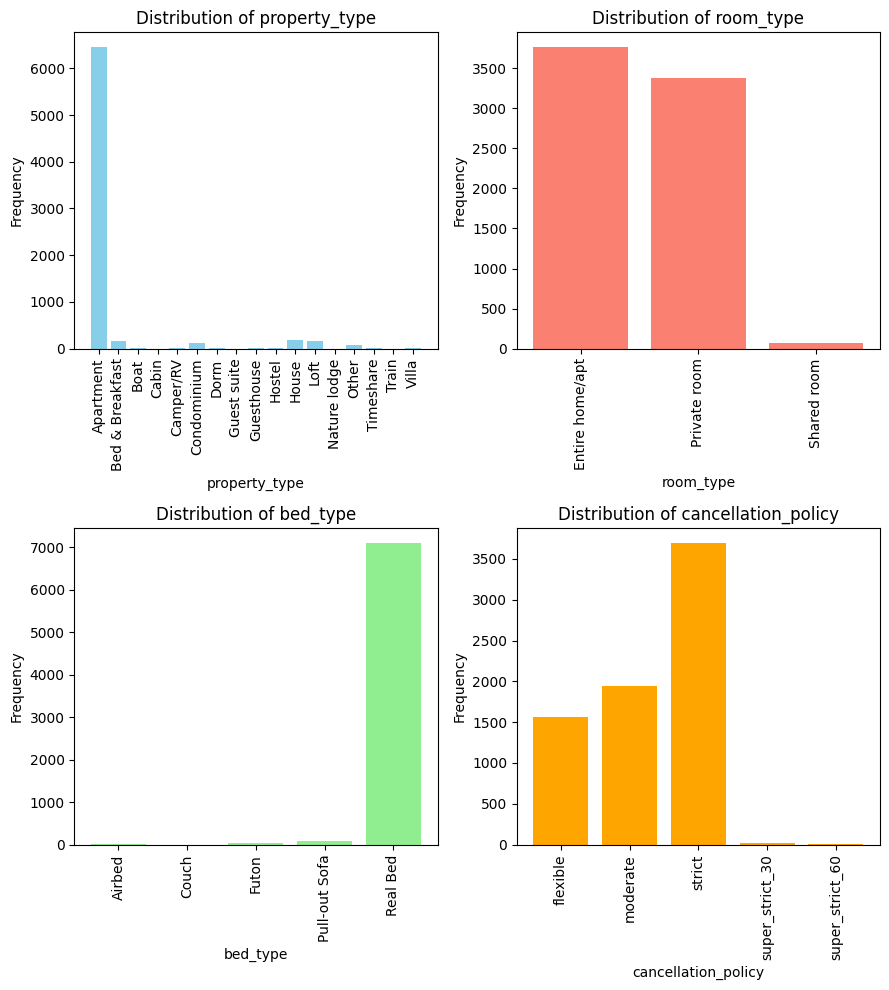

In [52]:
# Categorical features 
categorical_columns = ['property_type',	'room_type','bed_type', 'cancellation_policy']

fig, axs = plt.subplots(2, 2, figsize=(9, 10))  
axs = axs.flatten() 

for i, column in enumerate(categorical_columns):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_airbnb, column, ax, color)

plt.tight_layout()
plt.show()

### Sampling and Mapping Airbnb Listings in Barcelona

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">

+ A sample of the Airbnb dataset is being visualized on a map of Barcelona.
    + Due to rendering constraints, only a subset of the data is displayed.
+ Each marker represents a listing, with its location indicated by latitude and longitude coordinates.
+ The map is centered on Barcelona, providing an overview of the spatial distribution of Airbnb listings in the city. Distibuted locations.
</div>

In [53]:
'''
import folium
import random

# Submostra de les dades --> Costa renderitzar
sampled_data = df_airbnb.sample(withReplacement=False, fraction=0.1, seed=42)

# Map centered on Barcelona
map_barcelona = folium.Map(location=[41.3879, 2.1699], zoom_start=12)

# Add markers for each point in the sample
for row in sampled_data.collect():
    folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(icon='cloud')).add_to(map_barcelona) 

map_barcelona
'''

"\nimport folium\nimport random\n\n# Submostra de les dades --> Costa renderitzar\nsampled_data = df_airbnb.sample(withReplacement=False, fraction=0.1, seed=42)\n\n# Map centered on Barcelona\nmap_barcelona = folium.Map(location=[41.3879, 2.1699], zoom_start=12)\n\n# Add markers for each point in the sample\nfor row in sampled_data.collect():\n    folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(icon='cloud')).add_to(map_barcelona) \n\nmap_barcelona\n"

<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold;">
     TripAdvisor Locations Dataset
  </span>
</div>

In [54]:
df_locations = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_tripadvisor_locations") \
  .load()

# '.' errors with points --> rename cols
# Replace periods in column names with underscores
exprs = [f"`{col_name}` as `{col_name.replace('.', '_')}`" for col_name in df_locations.columns]
df_locations = df_locations.selectExpr(exprs)

print("The DataFrame has {} rows and {} columns. \n".format(df_locations.count(), len(df_locations.columns)))

df_locations.limit(2).toPandas() 

The DataFrame has 2493 rows and 14 columns. 



,location_id,name,distance,bearing,address_obj_street1,address_obj_city,address_obj_state,address_obj_country,address_obj_postalcode,address_obj_address_string,address_obj_street2,type,district,__index_level_0__
0,23525854,You Sushi,0.04040494581860683,northwest,"Carrer de Joan d' Austria, 22",Ibiza Town,Ibiza,Balearic Islands,07800,"Carrer de Joan d' Austria, 22, 07800, Ibiza To...",None,restaurant,Sant Martí,0
1,8821646,Prince A La Turca,0.10392565853481255,west,"Carrer De La Marina, 66",Barcelona,Province of Barcelona,Spain,08005,"Carrer De La Marina, 66, 08005 Barcelona Spain",None,restaurant,Sant Martí,1


In [55]:
# Checking  the NULL values
nan_counts = df_locations.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_locations.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,location_id,name,distance,bearing,address_obj_street1,address_obj_city,address_obj_state,address_obj_country,address_obj_postalcode,address_obj_address_string,address_obj_street2,type,district,__index_level_0__
0,0,0,0,0,47,0,1,0,106,0,1864,0,0,0



### Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ `distance`used on data collectors --> Redundant now
+ `bearning` is Compass bearing from the reference point to said apartment. --> Redudant now
+ `address_obj.street2`, `address_obj_postalcode` --> No need we will have the geolocation
+ `__index_level_0__` --> New index after changes
+ `address_obj.street1` (have NULLS) --> More information in `address_obj.address_string`  (No NULLS)--> only for retriving the geolocation data
+ Only keep the values located in Barcelona --> Then, the variable `address_obj_city` == Redundant

</div>



In [56]:
df_locations.select("address_obj_city").distinct().show()
df_locations = df_locations.filter(df_locations['address_obj_city'] == 'Barcelona')

+--------------------+
|    address_obj_city|
+--------------------+
|              Xativa|
|          Ibiza Town|
|             Peguera|
|Sant Cugat del Va...|
|Sant Andreu de la...|
|            Sabadell|
|           Barcelona|
|   Montcada i Reixac|
|              Sitges|
|L'Hospitalet de L...|
|          La Bordeta|
|            Valencia|
|         Los Abrigos|
|               Cadiz|
|Sant Feliu de Llo...|
+--------------------+



In [57]:
columns_to_drop = ["distance", "bearing", "address_obj_street2", "address_obj_postalcode", "__index_level_0__", "address_obj_street1", "address_obj_state", "address_obj_city", "address_obj_country" ]
df_locations = df_locations.drop(*columns_to_drop)

### Geolocalization function

<div class="alert alert-block alert-info" style="color: #1E88E5; background-color: #B2EBF2;">

+ We've crafted a geolocation function called `geolocalization_with_retry` to pinpoint addresses using the **Google Maps API** and `address_obj_address_string` feature. This function has the ability to retry geolocation several times in case of initial failure due to errors or timeouts. If successful, it returns the latitude and longitude coordinates of the provided address.

+ We've implemented a mechanism to avoid re-executing the geolocation code for addresses that have already been matched. This is achieved by saving the geolocation results to a file (`coordinates_dict.pkl`) and loading them from there for subsequent executions, preventing unnecessary repetition of the geocoding process.


+ We plotted the geolocations to visually identify any outliers. Then, we defined a square area to limit the zone of Barcelona, excluding any points that fall outside of this area.

</div>


In [58]:
# Takes too long --> It will be saved to a file for separate loading
import requests
import time

def geolocalization_with_retry(address, retries=3, sleep_time=5):
    api_key = '{your_key ;)}'
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"

    for attempt in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                lat = data['results'][0]['geometry']['location']['lat']
                lng = data['results'][0]['geometry']['location']['lng']
                return (lat, lng)
        time.sleep(sleep_time)  # Espera antes de reintentar
    return None

'''
coordinates_dict = {}
for row in df_locations.collect():
    address = row["address_obj_address_string"]
    location_id = row["location_id"]
    coordinates = geolocalization_with_retry(address)

    if coordinates:
        coordinates_dict[location_id] = coordinates
        #print(location_id, coordinates)
'''

'\ncoordinates_dict = {}\nfor row in df_locations.collect():\n    address = row["address_obj_address_string"]\n    location_id = row["location_id"]\n    coordinates = geolocalization_with_retry(address)\n\n    if coordinates:\n        coordinates_dict[location_id] = coordinates\n        #print(location_id, coordinates)\n'

In [59]:
file_name = "coordinates_dict.pkl"
'''
# Save de retrieved dict
with open(file_name, "wb") as file:
    pickle.dump(coordinates_dict, file)
'''
# Load de retrieved dict
with open(file_name, "rb") as file:
    coordinates_dict = pickle.load(file)

In [60]:
df_coordenadas = spark.createDataFrame(list(coordinates_dict.items()), ['location_id', 'coordinates'])
df_locations = df_locations.join(df_coordenadas, on='location_id', how='left')

In [61]:
df_locations = df_locations \
    .withColumn('coordinates_str', concat_ws(',', col('coordinates._1'), col('coordinates._2'))) \
    .withColumn('latitude', split(col('coordinates_str'), ',').getItem(0).cast('float')) \
    .withColumn('longitude', split(col('coordinates_str'), ',').getItem(1).cast('float')) \
    .drop(*['coordinates_str', 'coordinates'])  

df_locations.limit(2).toPandas()

,location_id,name,address_obj_address_string,type,district,latitude,longitude
0,27200794,Anna Subirats Xarcuteria,"Carrer De Sepulveda, 167, 08011 Barcelona Spain",restaurant,Eixample,41.383205,2.162197
1,27326644,Rincon Del Cazador,"Passeig De La Mare De Deu Del Coll, 68, 08023 ...",restaurant,Gràcia,41.417217,2.147516


In [62]:
# Outliers limit the zone
# Submostra de les dades --> Costa renderitzar
'''
sampled_data = df_locations.sample(withReplacement=False, fraction=0.1, seed=42)

sampled_data = df_locations.sample(withReplacement=False, fraction=0.1, seed=42)

# Map centered on Barcelona
map_barcelona = folium.Map(location=[41.3879, 2.1699], zoom_start=12)

# Add markers for each point in the sample
for row in sampled_data.collect():
    folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(icon='cloud')).add_to(map_barcelona) 

map_barcelona
'''


"\nsampled_data = df_locations.sample(withReplacement=False, fraction=0.1, seed=42)\n\nsampled_data = df_locations.sample(withReplacement=False, fraction=0.1, seed=42)\n\n# Map centered on Barcelona\nmap_barcelona = folium.Map(location=[41.3879, 2.1699], zoom_start=12)\n\n# Add markers for each point in the sample\nfor row in sampled_data.collect():\n    folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(icon='cloud')).add_to(map_barcelona) \n\nmap_barcelona\n"

In [63]:
import folium

# Limits of Barcelona
barcelona_lat_min = 41.33
barcelona_lat_max = 41.45
barcelona_lng_min = 2.10
barcelona_lng_max = 2.24

map_barcelona = folium.Map(location=[(barcelona_lat_min + barcelona_lat_max) / 2,
                                     (barcelona_lng_min + barcelona_lng_max) / 2], zoom_start=12)

# Square to paint
bounds = [(barcelona_lat_min, barcelona_lng_min),
          (barcelona_lat_min, barcelona_lng_max),
          (barcelona_lat_max, barcelona_lng_max),
          (barcelona_lat_max, barcelona_lng_min),
          (barcelona_lat_min, barcelona_lng_min)]

folium.Polygon(bounds, color='red', fill=True, fill_color='red', fill_opacity=0.5).add_to(map_barcelona)
map_barcelona


In [64]:
# Apply the square
df_barcelona = df_locations[(df_locations['latitude'] >= barcelona_lat_min) & 
                            (df_locations['latitude'] <= barcelona_lat_max) &
                            (df_locations['longitude'] >= barcelona_lng_min) & 
                            (df_locations['longitude'] <= barcelona_lng_max)]

In [65]:
df_barcelona.select("type").distinct().show()
df_barcelona.select("district").distinct().show()
# rename district to match to the other dfs
df_barcelona = df_barcelona.withColumnRenamed("district", "neighbourhood")

+----------+
|      type|
+----------+
|attraction|
|restaurant|
+----------+

+-------------------+
|           district|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+



<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">
    
### Categorical Features Distributions Insights
+ The majority of restaurants and attractions are located between Ciutat Vella and Example, where the highest volume of tourists is found.
+ We have slightly more restaurants than attractions, but the difference is fairly balanced.
</div>

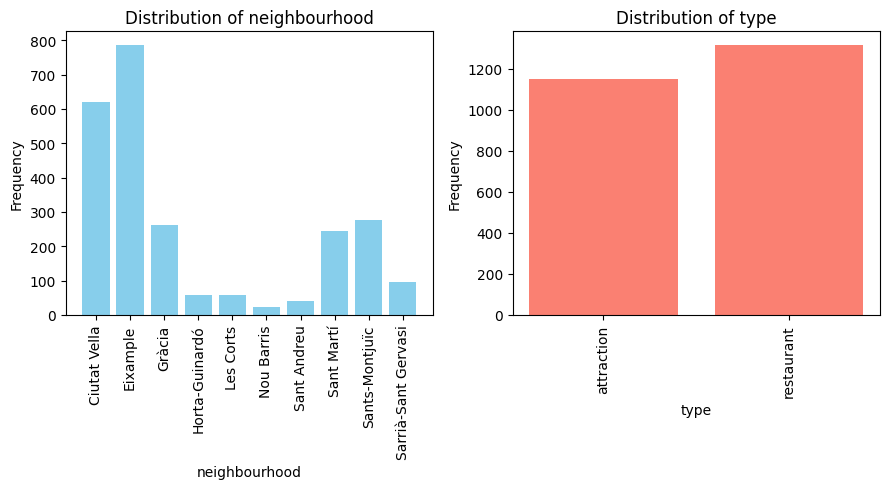

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))  
axs = axs.flatten() 

for i, column in enumerate(["neighbourhood", "type"]):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_barcelona, column, ax, color)

plt.tight_layout()
plt.show()

In [67]:
df_barcelona.printSchema()

root
 |-- location_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address_obj_address_string: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold;">
     TripAdvisor Reviews Datasets
  </span>
</div>

In [68]:
df_reviews = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_tripadvisor_reviews") \
  .load()

# '.' errors with points --> rename cols
# Replace periods in column names with underscores
exprs = [f"`{col_name}` as `{col_name.replace('.', '_')}`" for col_name in df_reviews.columns]
df_reviews = df_reviews.selectExpr(exprs)

df_reviews.limit(2).toPandas() 

,id,lang,location_id,published_date,rating,helpful_votes,rating_image_url,url,text,title,trip_type,travel_date,user_username,user_user_location_id,user_user_location_name,user_avatar_thumbnail,user_avatar_small,user_avatar_medium,user_avatar_large,user_avatar_original,subratings_0_name,subratings_0_rating_image_url,subratings_0_value,subratings_0_localized_name,subratings_1_name,subratings_1_rating_image_url,subratings_1_value,subratings_1_localized_name,subratings_2_name,subratings_2_rating_image_url,subratings_2_value,subratings_2_localized_name,subratings_3_name,subratings_3_rating_image_url,subratings_3_value,subratings_3_localized_name,owner_response_id,owner_response_title,owner_response_text,owner_response_lang,owner_response_author,owner_response_published_date
0,903790935,en,8821646,2023-07-17T19:52:18Z,5,0,https://www.tripadvisor.com/img/cdsi/img2/rati...,https://www.tripadvisor.com/ShowUserReviews-g1...,"Stopped for a light bites chicken, chips, rice...",Good value tasty food.,Family,2023-06-30,Wager47,255093,"Adelaide, Greater Adelaide, South Australia",https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,RATE_VALUE,https://www.tripadvisor.com/img/cdsi/img2/rati...,4.0,Value,RATE_SERVICE,https://www.tripadvisor.com/img/cdsi/img2/rati...,4.0,Service,RATE_FOOD,https://www.tripadvisor.com/img/cdsi/img2/rati...,4.0,Food,None,None,NaN,None,NaN,None,None,None,None,None
1,895366805,en,8821646,2023-06-16T01:59:36Z,4,0,https://www.tripadvisor.com/img/cdsi/img2/rati...,https://www.tripadvisor.com/ShowUserReviews-g1...,"Very nice view from the restaurant, decent pri...",👌,Family,2022-07-31,437kenzien,187497,"Barcelona, Catalonia",https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,None,None,NaN,None,None,None,NaN,None,None,None,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Explanation for Join Operation
We are performing a join operation between `df_reviews` and `df_barcelona` DataFrames on the 'location_id' column. This is done to filter `df_reviews` to only include rows corresponding to locations that are present in `df_barcelona`. By using an inner join (`how='inner'`), we ensure that only matching rows from both DataFrames are retained, effectively restricting our analysis to reviews for locations within Barcelona.

</div>


In [69]:
df_reviews_barcelona = df_reviews.join(df_barcelona, on='location_id', how='inner')
print("The DataFrame has {} rows and {} columns. \n".format(df_reviews_barcelona.count(), len(df_reviews_barcelona.columns)))


The DataFrame has 5449 rows and 48 columns. 



In [70]:
# Checking  the NULL values
nan_counts = df_reviews_barcelona.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_reviews_barcelona.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,location_id,id,lang,published_date,rating,helpful_votes,rating_image_url,url,text,title,trip_type,travel_date,user_username,user_user_location_id,user_user_location_name,user_avatar_thumbnail,user_avatar_small,user_avatar_medium,user_avatar_large,user_avatar_original,subratings_0_name,subratings_0_rating_image_url,subratings_0_value,subratings_0_localized_name,subratings_1_name,subratings_1_rating_image_url,subratings_1_value,subratings_1_localized_name,subratings_2_name,subratings_2_rating_image_url,subratings_2_value,subratings_2_localized_name,subratings_3_name,subratings_3_rating_image_url,subratings_3_value,subratings_3_localized_name,owner_response_id,owner_response_title,owner_response_text,owner_response_lang,owner_response_author,owner_response_published_date,name,address_obj_address_string,type,neighbourhood,latitude,longitude
0,0,0,0,0,0,0,0,0,0,0,34,34,0,0,1900,1,1,18,112,999,4311,4311,4311,4311,4322,4322,4322,4322,4346,4346,4346,4346,5070,5070,5070,5070,4973,4973,4973,4973,4973,4973,0,0,0,0,0,0


### Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ Values with lots of NaN --> drop

</div>

In [71]:
columns_to_drop = [
    "subratings_0_name",
    "subratings_0_rating_image_url",
    "subratings_0_value",
    "subratings_0_localized_name",
    "subratings_1_name",
    "subratings_1_rating_image_url",
    "subratings_1_value",
    "subratings_1_localized_name",
    "subratings_2_name",
    "subratings_2_rating_image_url",
    "subratings_2_value",
    "subratings_2_localized_name",
    "subratings_3_name",
    "subratings_3_rating_image_url",
    "subratings_3_value",
    "subratings_3_localized_name",
    "owner_response_id",
    "owner_response_title",
    "owner_response_text",
    "owner_response_lang",
    "owner_response_author",
    "owner_response_published_date",
    "user_user_location_name"
]
df_reviews_barcelona = df_reviews_barcelona.drop(*columns_to_drop)

In [72]:
df_reviews_barcelona.printSchema()

root
 |-- location_id: decimal(20,0) (nullable = true)
 |-- id: decimal(20,0) (nullable = true)
 |-- lang: string (nullable = true)
 |-- published_date: string (nullable = true)
 |-- rating: decimal(20,0) (nullable = true)
 |-- helpful_votes: decimal(20,0) (nullable = true)
 |-- rating_image_url: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- travel_date: string (nullable = true)
 |-- user_username: string (nullable = true)
 |-- user_user_location_id: string (nullable = true)
 |-- user_avatar_thumbnail: string (nullable = true)
 |-- user_avatar_small: string (nullable = true)
 |-- user_avatar_medium: string (nullable = true)
 |-- user_avatar_large: string (nullable = true)
 |-- user_avatar_original: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address_obj_address_string: string (nullable = true)
 |-- type: string (nullable = true)
 |--

In [73]:
## Prepare the DuckDB connection
con = duckdb.connect(database='./../data/trusted_zone/barcelona_processed.db', read_only=False)
con.close()

## Write on the tables 
print('Writting tables...')
jdbc_url = 'jdbc:duckdb:./../data/trusted_zone/barcelona_processed.db'
driver = "org.duckdb.DuckDBDriver"

print('    - Aribnb table')
df_airbnb.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_airbnb_listings") \
    .option("driver", driver) \
    .save()

print('    - Criminal table')
df_criminal.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_criminal_dataset") \
    .option("driver", driver) \
    .save()

print('    - Tripadvisor Locations table')
df_barcelona.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_tripadvisor_locations") \
    .option("driver", driver) \
    .save()

print('    - Tripadvisor Reviews table')
df_reviews_barcelona.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_tripadvisor_reviews") \
    .option("driver", driver) \
    .save()

spark.stop()

Writting tables...
    - Aribnb table


    - Criminal table
    - Tripadvisor Locations table


    - Tripadvisor Reviews table
